| Stage                              | What It Does                                                                                                                                                                           | Why It Matters                                                                 |
| ---------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- | ------------------------------------------------------------------------------ |
| **1. Search Direction**            | Starts from a *curated* list of seed search terms.                                                                                                                                     | Guarantees the crawl explores only relevant business domains.                  |
| **2. Smart Query Expansion**       | Uses LLMs to brainstorm semantically similar, SEO-friendly variations.                                                                                                                 | Uncovers long-tail queries Google ranks highly, boosting recall without noise. |
| **3. Candidate Harvesting**        | Pulls the top ***X*** Google results per query.                                                                                                                                        | Focuses bandwidth on high-authority pages.                                     |
| **4. Relevance Adjudication**      | Scores each result’s title, snippet, and rich-snippet metadata; keeps only those above a relevance threshold.                                                                          | Saves compute by filtering out tangential hits early.                          |
| **5. Crawl-History Check**         | Fast hash lookup against previously-seen URLs.                                                                                                                                         | Zero duplicate scrapes — we never fetch the same page twice.                   |
| **6. Site-Structure Discovery**    | For every surviving domain, the crawler probes for: <br>• **About Us**<br>• **Contact**<br>• **Services / Products**<br>• **Team / Staff**<br>• **Pricing**<br>• **Reviews / Ratings** | Ensures we capture *all* context-rich views of a company.                      |
| **7. HTML Acquisition & Cleaning** | Streams full DOM (incl. JS-rendered content), strips boilerplate, normalizes whitespace & encodings.                                                                                   | Produces lean, analysis-ready markup.                                          |
| **8. Field Extraction**            | LLM-powered parsers map clean HTML → structured schema (name, phones, e-mails, socials, pricing, etc.).                                                                                | Delivers ready-to-ingest JSON with minimal post-processing.                    |
| **9. De-duplication in DB**        | Queries for existing provider fingerprints; merges when matches found.                                                                                                                 | Keeps the database single-source-of-truth.                                     |
| **10. DB Ingestion**               | Inserts or updates the provider, its services, and all discovered attributes in PostgreSQL + PGVector.                                                                                 | Makes the data instantly searchable for downstream BI workflows.               |


In [1]:
import matplotlib.pyplot as plt
from asgiref.sync import sync_to_async
import django, sys, os


# ── Django bootstrap (unchanged) ──────────────────────────────────────
sys.path.insert(0, "/home/mohammed/Desktop/tech_projects/growbal/growbal_django")
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "growbal.settings")
django.setup()
from django.db import models

# ── ORM & helper imports ──────────────────────────────────────────────
from django.db.models import (
    Q, Count, Func, IntegerField, F        # ← added Func / IntegerField / F
)
from django.contrib.postgres.fields import ArrayField

# ── version-agnostic array_length() helper ────────────────────────────
try:                                   # Django ≥ 4.1
    from django.contrib.postgres.functions import ArrayLength

    def array_length_expr(field_name):
        return ArrayLength(field_name)

except ImportError:                    # Django ≤ 4.0
    class _ArrayLength(Func):
        function = "array_length"
        template = "%(function)s(%(expressions)s, 1)"
        output_field = IntegerField()

    def array_length_expr(field_name):
        return _ArrayLength(F(field_name))

# ── project models ────────────────────────────────────────────────────
from accounts.models import ServiceProviderProfile
from services.models import Service


# ══════════════════════════════════════════════════════════════════════
# 🔧  LOW-LEVEL HELPERS
# ══════════════════════════════════════════════════════════════════════
async def _acount(qs):
    return await sync_to_async(qs.count, thread_sensitive=True)()

async def _count_presence(model, field_name):
    """
    Return (with_value, without_value) for *field_name* on *model*.

    • Works for ArrayField, string-like fields, and numeric fields
      (DecimalField, IntegerField, FloatField …).
    """
    field  = model._meta.get_field(field_name)
    total  = await _acount(model.objects.all())

    # ---- ArrayField ---------------------------------------------------
    if isinstance(field, ArrayField):
        qs_with = (
            model.objects
            .annotate(_len=array_length_expr(field_name))
            .filter(_len__gt=0)
        )

    # ---- String-like fields (need “not empty” check) ------------------
    elif isinstance(field, (models.CharField, models.TextField,
                            models.URLField, models.EmailField, models.SlugField)):
        qs_with = (
            model.objects
            .exclude(**{f"{field_name}__isnull": True})
            .exclude(**{f"{field_name}": ""})
        )

    # ---- Numeric / Boolean / Date … → just “NOT NULL” ----------------
    else:
        qs_with = model.objects.exclude(**{f"{field_name}__isnull": True})

    with_val = await _acount(qs_with)
    return with_val, total - with_val



def _plot_pie(sizes, labels, title, figsize=(8, 8)):
    """
    Draw a single pie chart at the requested size.

    Parameters
    ----------
    sizes    : list[int|float]
    labels   : list[str]
    title    : str
    figsize  : tuple[int, int]  – width × height in inches
    """
    plt.figure(figsize=figsize)
    plt.pie(sizes, labels=labels, autopct="%1.1f%%", startangle=90)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# ══════════════════════════════════════════════════════════════════════
# 📊  HIGH-LEVEL CHARTS
# ══════════════════════════════════════════════════════════════════════
async def _chart_presence_both_models(fields):
    """
    Pie chart per model showing rows that have **at least ONE** of the
    given *fields* populated.

    Parameters
    ----------
    fields : list[str]
        Field names to test on each model.
    """
    async def _presence_any(model):
        annotations = {}
        q_any       = Q()

        for f_name in fields:
            if f_name not in [f.name for f in model._meta.get_fields()]:
                continue      # skip missing fields silently

            field = model._meta.get_field(f_name)

            if isinstance(field, ArrayField):
                ann = f"{f_name}_len"
                annotations[ann] = array_length_expr(f_name)
                q_any |= Q(**{f"{ann}__gt": 0})

            elif isinstance(field, (models.CharField, models.TextField,
                                     models.URLField, models.EmailField, models.SlugField)):
                q_any |= (~Q(**{f_name: None}) & ~Q(**{f_name: ""}))

            else:  # numeric / date / bool …
                q_any |= Q(**{f"{f_name}__isnull": False})

        qs = model.objects.annotate(**annotations).filter(q_any)
        with_any = await _acount(qs)
        total    = await _acount(model.objects.all())
        return with_any, total - with_any

    # ---------- ServiceProviderProfile pie -----------------------------
    if any(f in [g.name for g in ServiceProviderProfile._meta.get_fields()] for f in fields):
        pr_with, pr_without = await _presence_any(ServiceProviderProfile)
        _plot_pie([pr_with, pr_without],
                  [f"≥1 of {fields}", "none"],
                  f"ServiceProviderProfile – any of {fields}")

    # ---------- Service pie (only if at least one field exists) --------
    if any(f in [g.name for g in Service._meta.get_fields()] for f in fields):
        svc_with, svc_without = await _presence_any(Service)
        _plot_pie([svc_with, svc_without],
                  [f"≥1 of {fields}", "none"],
                  f"Service – any of {fields}")

async def _chart_any_contact(contact_fields):
    """
    Pie-chart: profiles that have *any* contact info
               (website / social / phone OR at least one email)
    """
    # contact_fields = [
    #     # "website",
    #     # "linkedin",
    #     # "facebook",
    #     # "instagram", 
    #     "telephone", 
    #     # "mobile",
    # ]

    # OR-chain for the scalar fields
    q_any_scalar = Q()
    for f in contact_fields:
        q_any_scalar |= (~Q(**{f: None}) & ~Q(**{f: ""}))

    # Single queryset:
    #   annotate array length  → emails_len
    #   filter for (scalar hit) OR (emails_len > 0)
    qs_any = (
        ServiceProviderProfile.objects
        .annotate(emails_len=array_length_expr("emails"))
        .filter(q_any_scalar | Q(emails_len__gt=0))
    )

    with_any = await _acount(qs_any)
    total    = await _acount(ServiceProviderProfile.objects.all())

    contact_fields = ", ".join(contact_fields)
    _plot_pie(
        [with_any, total - with_any],
        ["≥ 1 contact field", "no contact fields"],
        f"ServiceProviderProfile – with {contact_fields} or email" if contact_fields else "ServiceProviderProfile – with email",
    )

async def _chart_any_presence(fields):
    """
    Pie chart showing how many ServiceProviderProfile rows have
    at least ONE non-empty value among the given *fields*.

    Parameters
    ----------
    fields : list[str]
        Field names on ServiceProviderProfile.  Supports both
        scalar fields (CharField, URLField, …) and ArrayField.
    """
    # ------------------------------------------------------------
    # Build: annotations  +  OR-chain for "has value" predicates
    # ------------------------------------------------------------
    annotations = {}
    q_any       = Q()

    for f_name in fields:
        field = ServiceProviderProfile._meta.get_field(f_name)

        # ---- ArrayField → length > 0 ---------------------------------
        if isinstance(field, ArrayField):
            ann_name = f"{f_name}_len"
            annotations[ann_name] = array_length_expr(f_name)
            q_any |= Q(**{f"{ann_name}__gt": 0})

        # ---- Scalar field → NOT NULL / NOT empty string --------------
        else:
            q_any |= (~Q(**{f_name: None}) & ~Q(**{f_name: ""}))

    # ------------------------------------------------------------
    # Query & plot
    # ------------------------------------------------------------
    qs_any = (
        ServiceProviderProfile.objects
        .annotate(**annotations)     # adds any array-length calcs
        .filter(q_any)               # rows with ≥1 field populated
    )

    with_any = await _acount(qs_any)
    total    = await _acount(ServiceProviderProfile.objects.all())

    label_fields = ", ".join(fields)
    _plot_pie(
        [with_any, total - with_any],
        ["≥ 1 field", "no fields"],
        f"ServiceProviderProfile – any of [{label_fields}] present",
    )


async def _chart_country_breakdown(figsize=(9, 9), pct_threshold=3):
    """
    Pie chart of providers by country.

    Any slice whose percentage is below *pct_threshold* will have
    **neither** its label nor its percentage displayed.

    Parameters
    ----------
    figsize : tuple[int, int]
        Figure size passed to plt.subplots().
    pct_threshold : float
        Minimum slice share (%) for showing label + percentage.
    """
    # 1️⃣  Fetch data
    rows = await sync_to_async(
        list, thread_sensitive=True
    )(
        ServiceProviderProfile.objects
        .values("country")
        .annotate(c=Count("id"))
        .order_by("-c")
    )

    labels = [(r["country"] or "Unknown") for r in rows]
    sizes  = [r["c"] for r in rows]
    total  = sum(sizes)

    # 2️⃣  Suppress labels below threshold
    display_labels = []
    for lbl, sz in zip(labels, sizes):
        pct = 100 * sz / total
        display_labels.append(lbl if pct >= pct_threshold else "")

    def autopct_fmt(pct):
        return f"{pct:.1f}%" if pct >= pct_threshold else ""

    # 3️⃣  Plot
    fig, ax = plt.subplots(figsize=figsize)
    wedges, _, _ = ax.pie(
        sizes,
        labels=display_labels,
        autopct=autopct_fmt,
        startangle=90,
        labeldistance=1.05,
        pctdistance=0.75,
    )
    ax.set_title("ServiceProviderProfile – providers by country")
    plt.tight_layout()
    plt.show()


In [18]:
async def quick_overview():
    """Print counts of distinct countries, e-mails, telephones, mobiles."""
    qs = ServiceProviderProfile.objects.all()

    # ── distinct countries (non-null / non-empty) ──────────────────────
    countries_cnt = await sync_to_async(
        qs.filter(country__isnull=False)
          .exclude(country="")
          .values_list("country", flat=True)
          .distinct()
          .count,
        thread_sensitive=True,
    )()

    # ── distinct telephone numbers ─────────────────────────────────────
    telephone_cnt = await sync_to_async(
        qs.filter(telephone__isnull=False)
          .exclude(telephone="")
          .values_list("telephone", flat=True)
          .distinct()
          .count,
        thread_sensitive=True,
    )()

    # ── distinct mobile numbers ────────────────────────────────────────
    mobile_cnt = await sync_to_async(
        qs.filter(mobile__isnull=False)
          .exclude(mobile="")
          .values_list("mobile", flat=True)
          .distinct()
          .count,
        thread_sensitive=True,
    )()

    # ── distinct emails (ArrayField → flatten in Python) ───────────────
    # Pull just the emails column (list[str]) for every profile
    all_email_lists = await sync_to_async(
        list, thread_sensitive=True
    )(qs.values_list("emails", flat=True))

    email_set = {
        email.strip().lower()
        for email_list in all_email_lists if email_list  # skip None/[]
        for email in email_list if email                 # skip empty strings
    }
    email_cnt = len(email_set)

    # ── print overview ─────────────────────────────────────────────────
    print("──────────────────────────  OVERVIEW  ──────────────────────────")
    print(f"🌍  Unique countries : {countries_cnt}")
    print(f"✉️   Unique e-mails  : {email_cnt}")
    print(f"☎️   Unique telephone: {telephone_cnt}")
    print(f"📱  Unique mobile    : {mobile_cnt}")
    print("─────────────────────────────────────────────────────────────────")


In [19]:
await quick_overview()

──────────────────────────  OVERVIEW  ──────────────────────────
🌍  Unique countries : 35
✉️   Unique e-mails  : 157
☎️   Unique telephone: 134
📱  Unique mobile    : 83
─────────────────────────────────────────────────────────────────


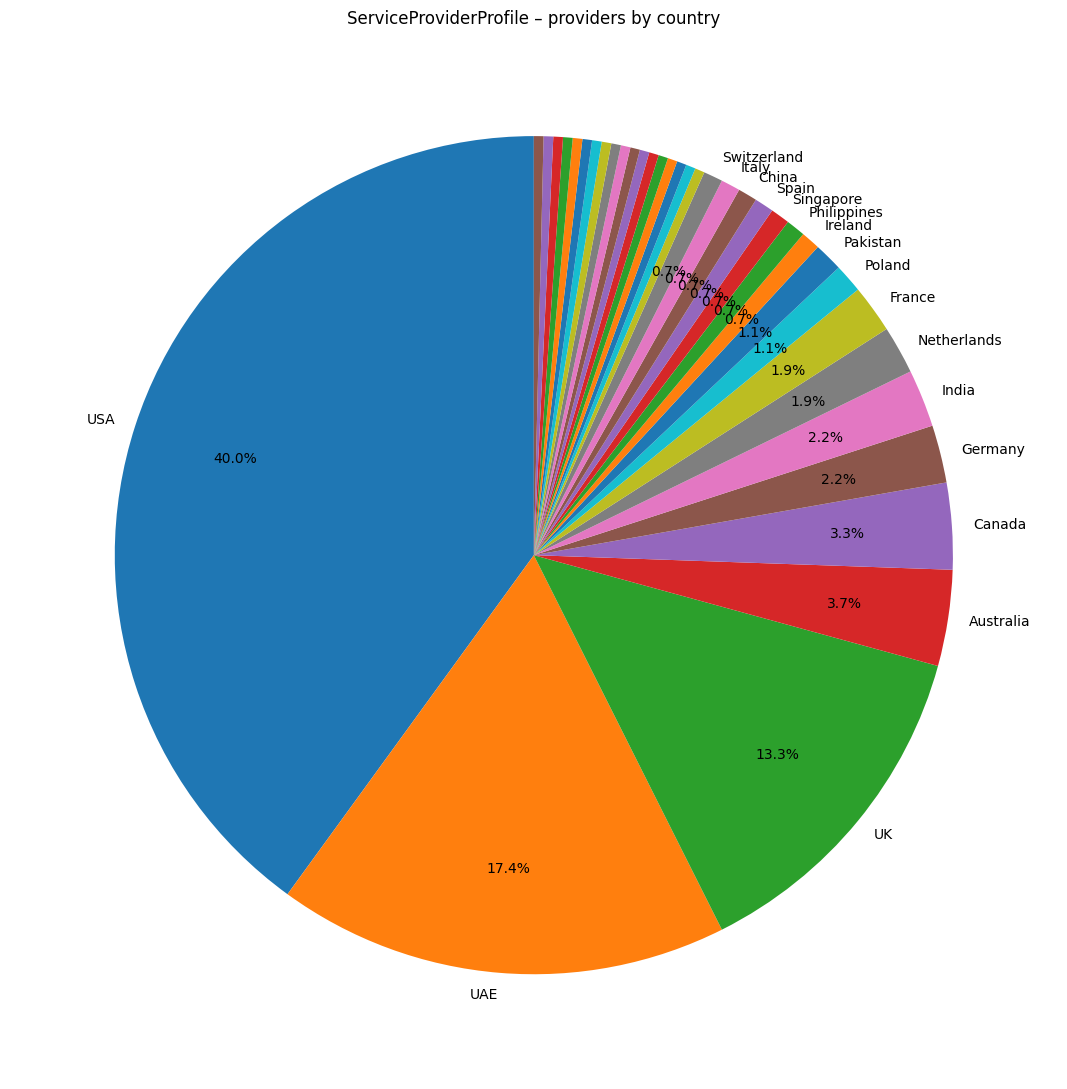

In [2]:
await _chart_country_breakdown(figsize=(11,11), pct_threshold=.7)

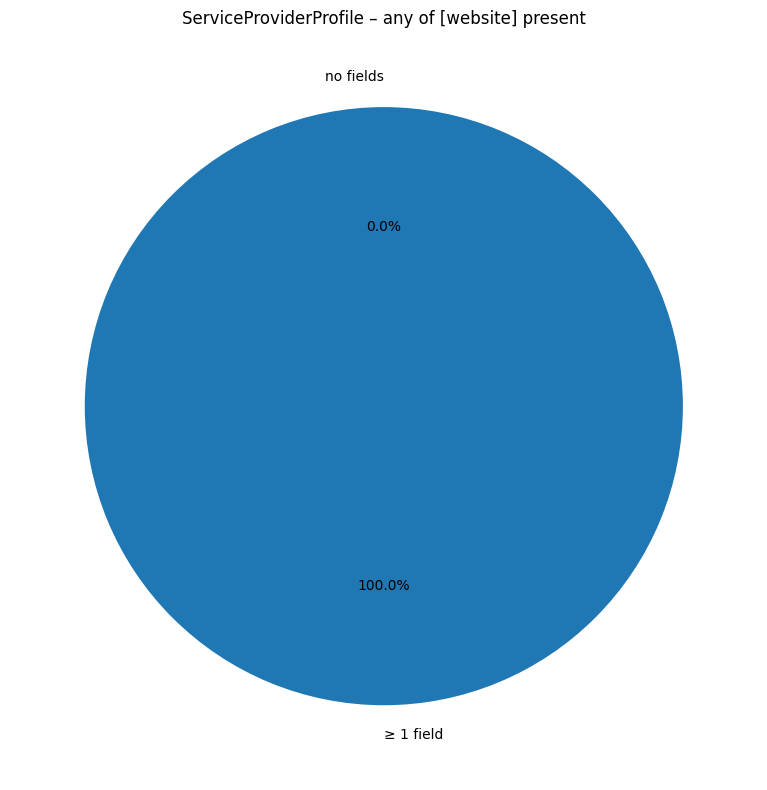

In [3]:
await _chart_any_presence(["website"])

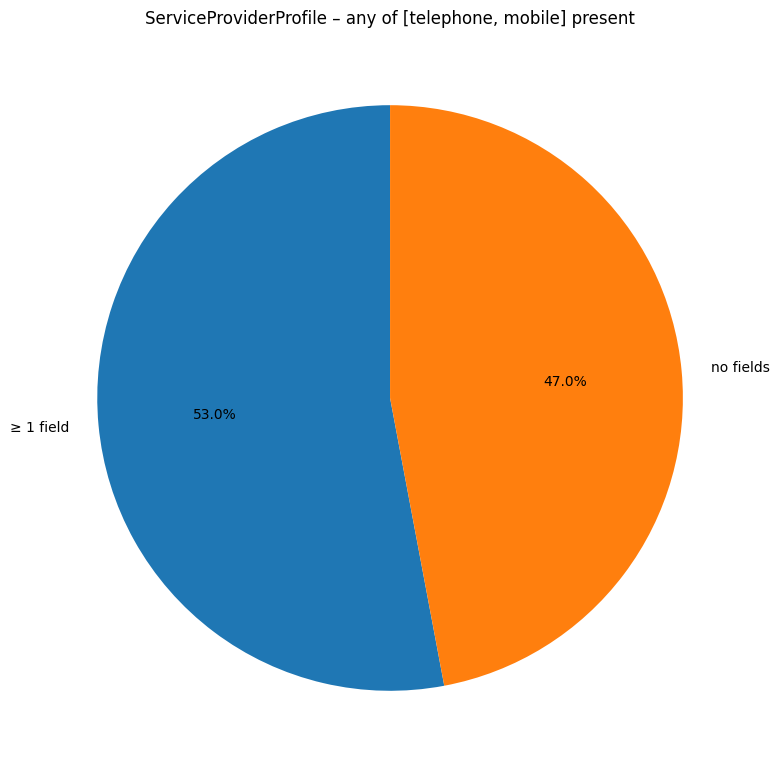

In [4]:
await _chart_any_presence(["telephone", "mobile"])

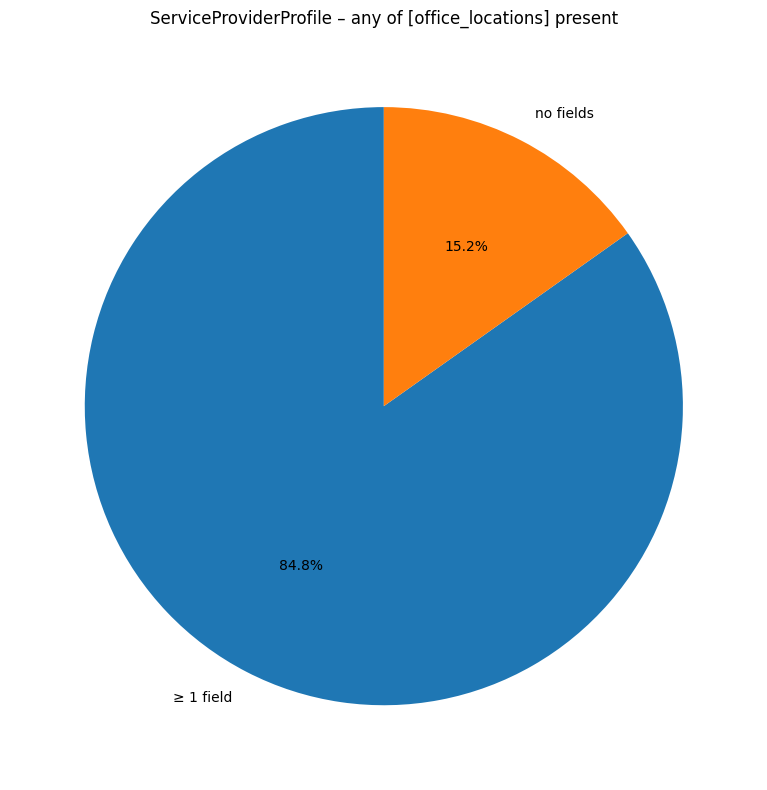

In [16]:
await _chart_any_presence(["office_locations"])

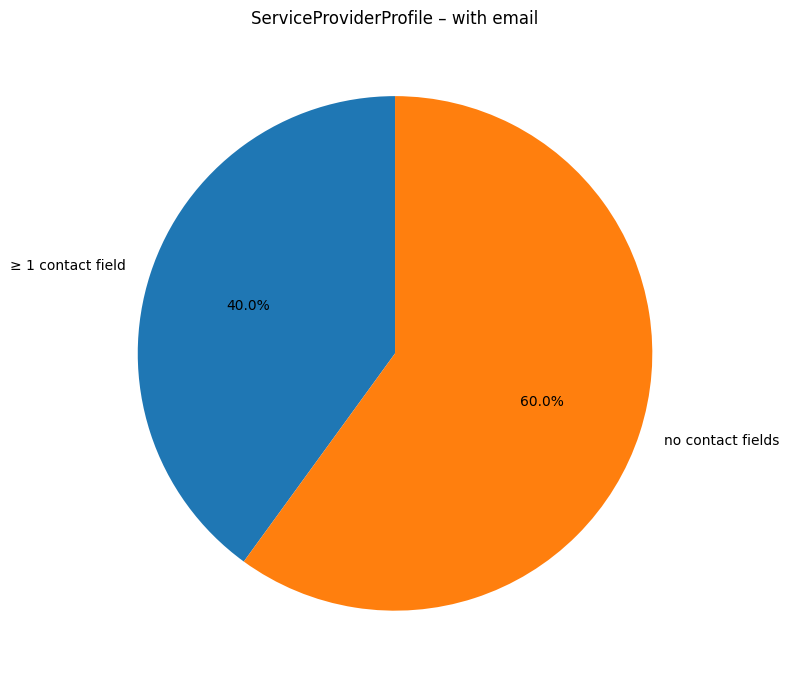

In [5]:
await _chart_any_contact([])

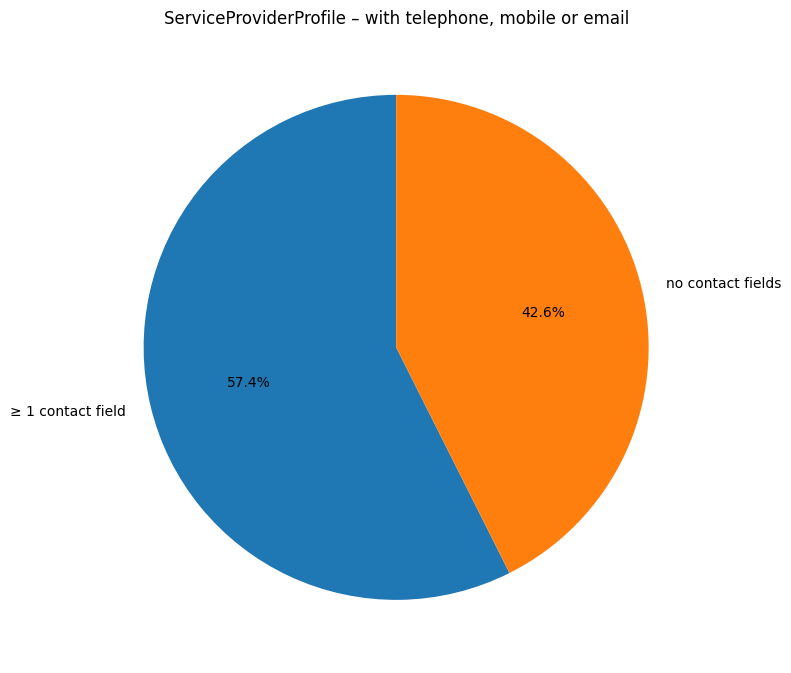

In [6]:
await _chart_any_contact(["telephone","mobile"])

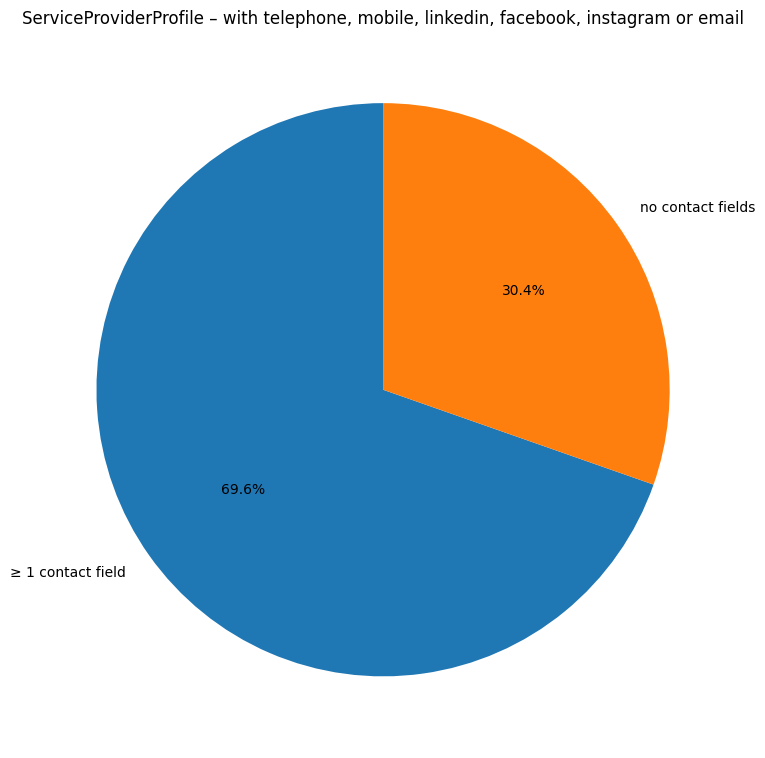

In [7]:
await _chart_any_contact(["telephone","mobile", "linkedin", "facebook", "instagram"])

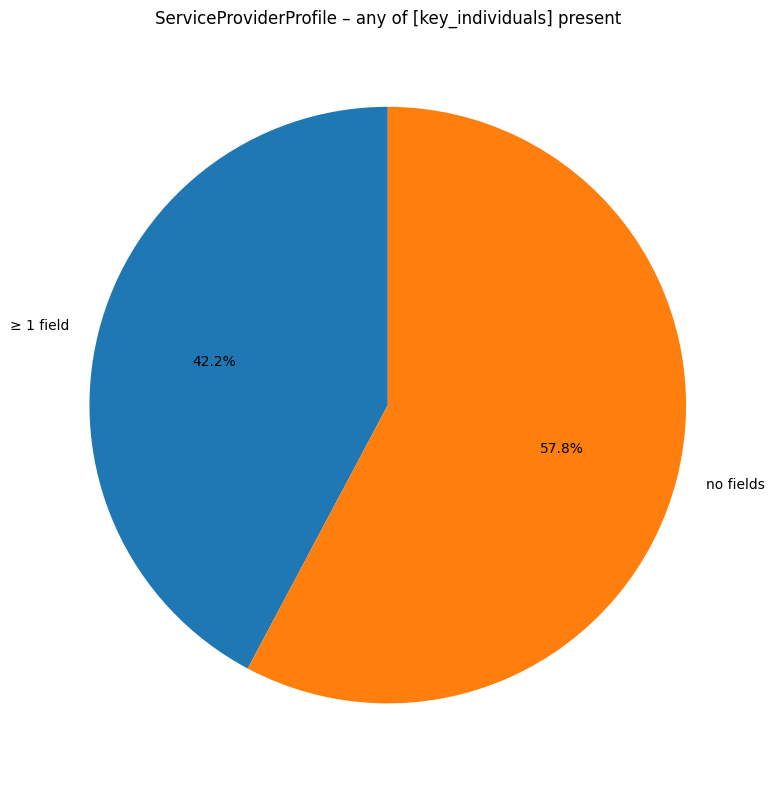

In [17]:
await _chart_any_presence(["key_individuals"])

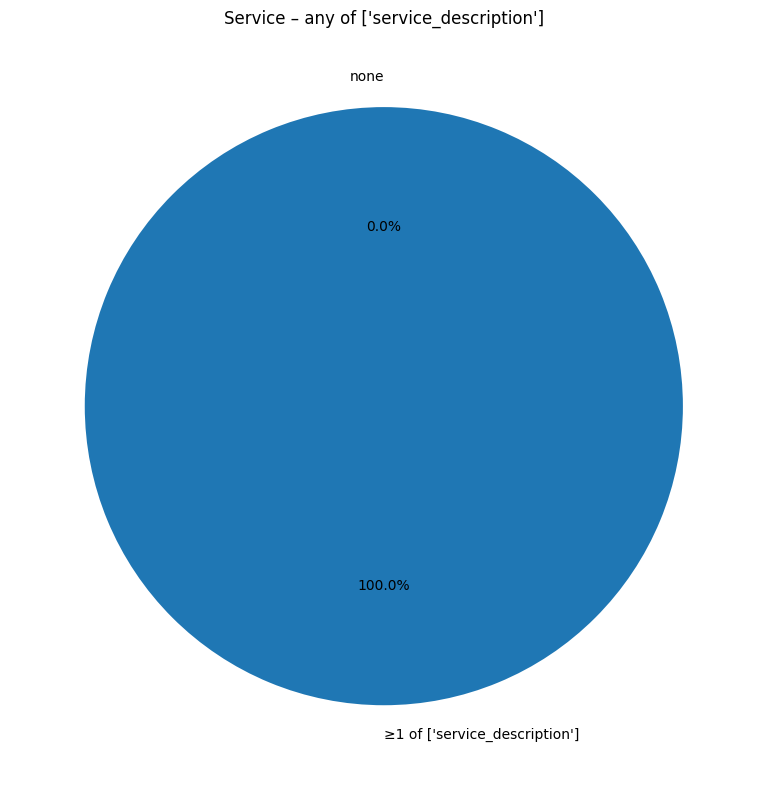

In [12]:
await _chart_presence_both_models(["service_description"])

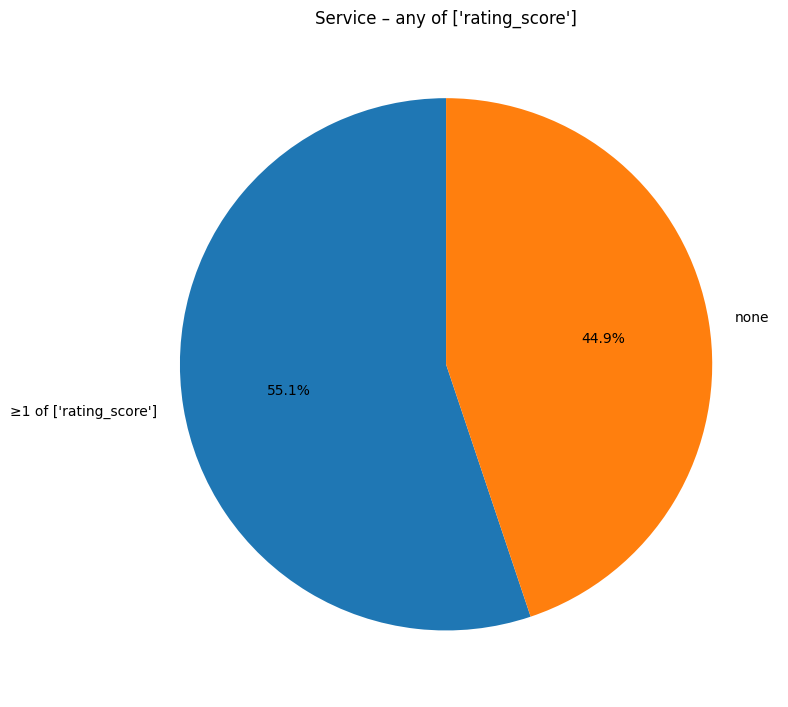

In [9]:
await _chart_presence_both_models(["rating_score"])

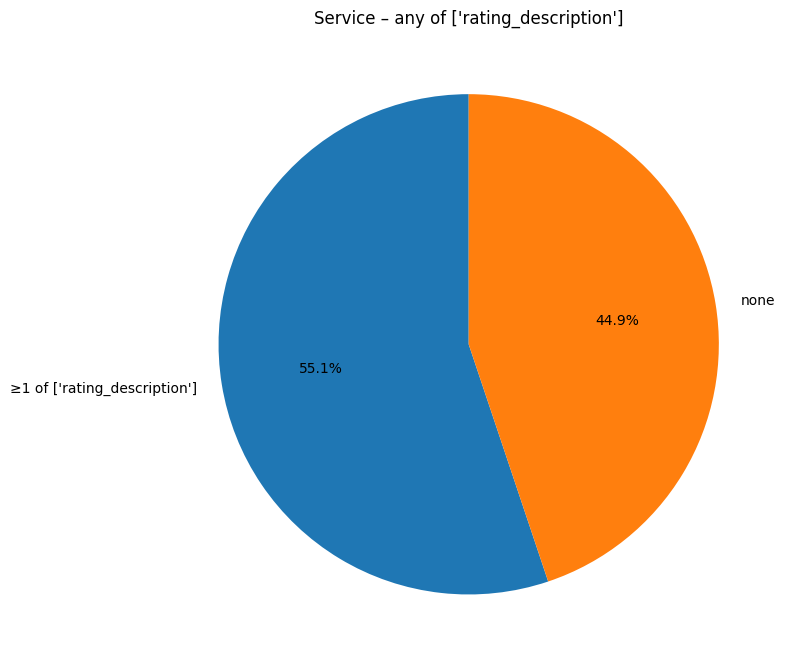

In [10]:
await _chart_presence_both_models(["rating_description"])

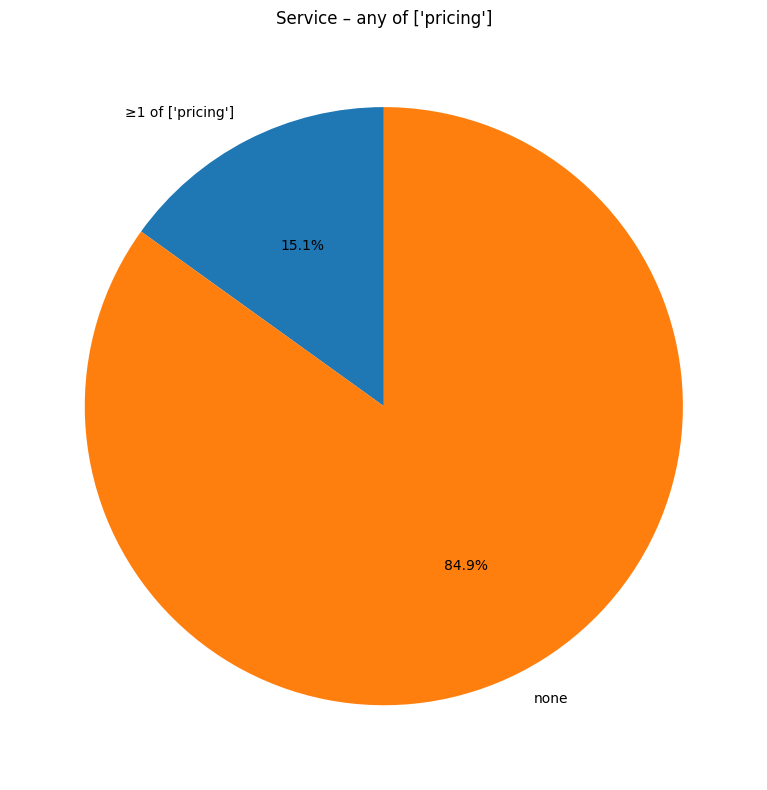

In [14]:
await _chart_presence_both_models(["pricing"])